# Define Area Of Interest (AOI) for ICESat-2 Data Retrieval  

- Version #1. Use terminus position of tidewater glaciers in Feb 2019 from NSIDC-0642  
- Version #2. Create polygon based on flowlines from Felikson et al. (2020) (Data [here](https://doi.org/10.5281/zenodo.4284759))  
- Version #3. Combine 1 and 2? or use the existing grounding line datasets?

In [29]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import substring, unary_union
from pyproj import Transformer
import xarray as xr
from datetime import datetime
import ee
import geemap

%matplotlib inline

In [2]:
### Functions 

## Reprojection using pyproj
def reproj(X, Y, source_epsg, target_epsg):
    lon = []
    lat = []
    transformer = Transformer.from_crs(source_epsg, target_epsg, always_xy=True)

    if len(X) == len(Y):
        for i in range(len(X)):
            lon1, lat1 = transformer.transform(X[i], Y[i])
            lon.append(lon1)
            lat.append(lat1)
    else:
        raise ValueError("X and Y must be of the same length.")
    return lon, lat

In [3]:

f_glacier_loc = "data/Terminus_change/GlacierIDs_v02.0/GlacierIDs_v02.0.shp"
glacier_loc = gpd.read_file(f_glacier_loc)

glacier_loc = glacier_loc.sort_values('GlacierID').reset_index(drop = True)
glacier_loc


,GlacierID,POINT_X,POINT_Y,GrnlndcNam,Official_n,AltName,geometry
0,1,-213962.001560,-2.302891e+06,Saqqarliup Sermia,Saqqarliup Sermia,Sarqardliup Sermia,POINT (-213962.002 -2302890.748)
1,2,-209632.753050,-2.296369e+06,Alanngorliup Sermia,Alanngorliup Sermia,Alangordliup Sermia,POINT (-209632.753 -2296369.242)
2,3,-182396.466724,-2.276270e+06,Sermeq Kujalleq,Sermeq Kujalleq,Jakobshavn Isbræ,POINT (-182396.467 -2276270.1)
3,4,-208728.362981,-2.249029e+06,Sermeq Avannarleq,Sermeq Avannarleq,Sermeq Avannarleq A,POINT (-208728.363 -2249029.325)
4,5,-201747.610542,-2.201924e+06,Eqip Sermia,Eqip Sermia,None,POINT (-201747.611 -2201924.089)
...,...,...,...,...,...,...,...
234,235,0.000000,0.000000e+00,None,None,None,POINT (76568.867 -3224123.613)
235,236,-8982.936059,-3.182632e+06,Qooqqup Sermia,Qooqqup Sermia,None,POINT (-8982.936 -3182631.942)
236,237,601247.799569,-1.440716e+06,None,Stormgletsjer,Ejnar Mikkelsen Gletsjer,POINT (601247.8 -1440716.365)
237,238,67582.275852,-3.238635e+06,None,None,None,POINT (67582.276 -3238635.339)


## V1: use terminus position with a buffer

In [25]:

tp_2019_fn = "data/Terminus_change/2019.02.03/termini_2018_2019_v02.0.shp"
tp_2019 = gpd.read_file(tp_2019_fn)
tp_2019 = tp_2019.sort_values('Glacier_ID').reset_index(drop = True)

tp_2019


,Image_ID,Sensor,Glacier_ID,Quality_Fl,SourceDate,geometry
0,SEN1_NSIDC_0723_V4_20190203_20190208,SEN1,1,0,2019-02-05,"LINESTRING (-216898.882 -2300631.202, -216771...."
1,SEN1_NSIDC_0723_V4_20190203_20190208,SEN1,2,0,2019-02-05,"LINESTRING (-211119.714 -2294998.697, -211035...."
2,SEN1_NSIDC_0723_V4_20190203_20190208,SEN1,3,1,2019-02-05,"LINESTRING (-185841.349 -2276487.059, -185788...."
3,SEN1_NSIDC_0723_V4_20190203_20190208,SEN1,4,0,2019-02-05,"LINESTRING (-207696.486 -2250526.87, -207749.4..."
4,SEN1_NSIDC_0723_V4_20190203_20190208,SEN1,5,0,2019-02-05,"LINESTRING (-200567.566 -2203315.8, -200631.06..."
...,...,...,...,...,...,...
234,SEN1_NSIDC_0723_V4_20190203_20190208,SEN1,235,0,2019-02-07,"LINESTRING (79145.914 -3225758.741, 79156.497 ..."
235,SEN1_NSIDC_0723_V4_20190203_20190208,SEN1,236,0,2019-02-05,"LINESTRING (-11803.4 -3184531.654, -11750.483 ..."
236,SEN1_NSIDC_0723_V4_20190203_20190208,SEN1,237,0,2019-02-05,"LINESTRING (606195.518 -1441695.325, 606110.85..."
237,SEN1_NSIDC_0723_V4_20190203_20190208,SEN1,238,0,2019-02-07,"LINESTRING (68582.403 -3239265.049, 68497.736 ..."


In [26]:
## Find lower-left coordinate and upper-right coordinate

scalar = 1 # Use 1 * length of calving front as the buffer??

ll_lon_l = []
ll_lat_l = []
ur_lon_l = []
ur_lat_l = []

for i in range(len(glacier_loc)):
    x = tp_2019["geometry"].values[i].coords.xy[0]
    y = tp_2019["geometry"].values[i].coords.xy[1]
    
    len_tp = np.sqrt(np.square(np.abs(x[0] - x[-1])) + np.square(np.abs(y[0] - y[-1]))) # Get length of terminus position
    
    # Use the location of tidewater glaciers, and use scalar*length of terminus position as the buffer
    llx = glacier_loc["POINT_X"].values[i] - scalar*len_tp
    lly = glacier_loc["POINT_Y"].values[i] - scalar*len_tp
    urx = glacier_loc["POINT_X"].values[i] + scalar*len_tp
    ury = glacier_loc["POINT_Y"].values[i] + scalar*len_tp

    # Get lower-left corner longitude and latitude (ll_lon, ll_lat) and upper-right corner required for bounding box
    ll_lon, ll_lat = reproj([llx], [lly], "epsg:3413", "epsg:4326")
    ur_lon, ur_lat = reproj([urx], [ury], "epsg:3413", "epsg:4326")

    ll_lon_l.append(ll_lon)
    ll_lat_l.append(ll_lat)
    ur_lon_l.append(ur_lon)
    ur_lat_l.append(ur_lat)

# Add to the dataframe
glacier_loc["ll_lon"] = np.asarray(ll_lon_l)
glacier_loc["ll_lat"] = np.asarray(ll_lat_l)
glacier_loc["ur_lon"] = np.asarray(ur_lon_l)
glacier_loc["ur_lat"] = np.asarray(ur_lat_l)


In [42]:
glacier_loc

,GlacierID,POINT_X,POINT_Y,GrnlndcNam,Official_n,AltName,geometry,ll_lon,ll_lat,ur_lon,ur_lat
0,1,-213962.001560,-2.302891e+06,Saqqarliup Sermia,Saqqarliup Sermia,Sarqardliup Sermia,POINT (-213962.002 -2302890.748),-50.421910,68.832905,-50.193788,68.932015
1,2,-209632.753050,-2.296369e+06,Alanngorliup Sermia,Alanngorliup Sermia,Alangordliup Sermia,POINT (-209632.753 -2296369.242),-50.273619,68.919142,-50.158251,68.968963
2,3,-182396.466724,-2.276270e+06,Sermeq Kujalleq,Sermeq Kujalleq,Jakobshavn Isbræ,POINT (-182396.467 -2276270.1),-49.818167,69.044083,-49.342103,69.243266
3,4,-208728.362981,-2.249029e+06,Sermeq Avannarleq,Sermeq Avannarleq,Sermeq Avannarleq A,POINT (-208728.363 -2249029.325),-50.384852,69.331135,-50.219519,69.401377
4,5,-201747.610542,-2.201924e+06,Eqip Sermia,Eqip Sermia,None,POINT (-201747.611 -2201924.089),-50.318415,69.757205,-50.151319,69.826624
...,...,...,...,...,...,...,...,...,...,...,...
234,235,0.000000,0.000000e+00,None,None,None,POINT (76568.867 -3224123.613),-90.000000,89.979229,90.000000,89.979229
235,236,-8982.936059,-3.182632e+06,Qooqqup Sermia,Qooqqup Sermia,None,POINT (-8982.936 -3182631.942),-45.201584,61.197315,-45.121792,61.236013
236,237,601247.799569,-1.440716e+06,None,Stormgletsjer,Ejnar Mikkelsen Gletsjer,POINT (601247.8 -1440716.365),-22.537342,75.641558,-22.158090,75.680188
237,238,67582.275852,-3.238635e+06,None,None,None,POINT (67582.276 -3238635.339),-43.832752,60.711721,-43.776327,60.738227


In [43]:
glacier_loc[glacier_loc["GlacierID"]==93]

,GlacierID,POINT_X,POINT_Y,GrnlndcNam,Official_n,AltName,geometry,ll_lon,ll_lat,ur_lon,ur_lat
92,93,-276331.933066,-932569.503686,None,Petermann Gletsjer,Petermann Gletscher,POINT (-276331.933 -932569.504),-62.142068,80.851638,-60.841161,81.224819


In [44]:
glacier_loc.to_csv("data/glacier_loc_bb.csv", index = False)

## V2: Use flowline from [Felikson et al. (2020)](https://doi.org/10.1029/2020GL090112) (Data [here](https://doi.org/10.5281/zenodo.4284759))

  flowline                                           geometry
0       03  LINESTRING (-256919.24 -990469.188, -256759.54...
1       04  LINESTRING (-258598.286 -990947.791, -258439.7...
2       05  LINESTRING (-260221.267 -991177.469, -260063.3...
3       06  LINESTRING (-262369.345 -990660.265, -262209.8...
4       07  LINESTRING (-264787.335 -990399.005, -264628.8...
5       08  LINESTRING (-266044.866 -991395.165, -265888.3...


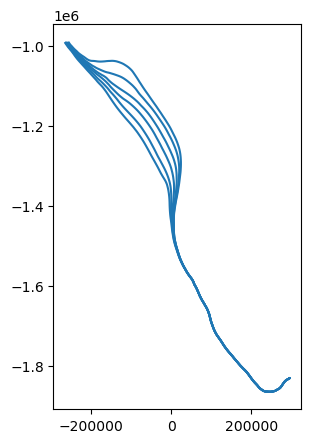

In [21]:
## Read and visualize the flowline file for Petermann glacier in north Greenland

flowline_f = "data/Flowline_Felikson2020/glacier0099.shp"

flowline = gpd.read_file(flowline_f)
print(flowline)

gpd.GeoSeries(flowline["geometry"]).plot(figsize =(10, 5))
plt.show()

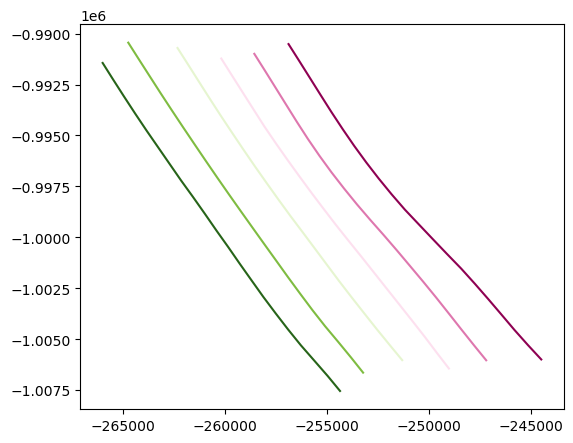

In [38]:
## Subset flowline and plot


dis_to_start = 20000
interval = 1000

fig, ax = plt.subplots(figsize=(8, 5))
cmap = plt.get_cmap('PiYG', len(flowline))

fl_subset_l = []
for i in range(len(flowline)):
    # Take the ith flowline
    fl1 = flowline["geometry"][i]
    
    # Subset flowline based on the distance to the starting point
    
    fl1_sub = substring(fl1, 0, 0+dis_to_start)
    
    # Resample flowline to regular/user-defined intervals
    
    distances = np.arange(0, fl1_sub.length, interval)
    points = [fl1_sub.interpolate(distance) for distance in distances] # Resample line to points
    multipoint = unary_union(points) # Create multipoint from points
    fl1_r = LineString(points) # Create linestring from multipoint
    
    fl_subset_l.append(fl1_r)

    # Plot
    gpd.GeoSeries(fl1_r).plot(ax = ax, color = cmap(i))
    
plt.show()


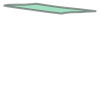

In [39]:
## Create polygon based on the flowlines

x_coords = []
y_coords = []
for i, line in enumerate(fl_subset_l):
    if i == 0:
        x_coords.extend(line.coords.xy[0])
        y_coords.extend(line.coords.xy[1])
    elif i == len(fl_subset_l)-1:
        x_coords.extend(list(reversed(line.coords.xy[0])))
        y_coords.extend(list(reversed(line.coords.xy[1])))
    else:
        x_coords.append(line.coords.xy[0][-1])
        y_coords.append(line.coords.xy[1][-1])

for i, line in enumerate(list(reversed(fl_subset_l))[1:]):
    x_coords.append(line.coords.xy[0][0])
    y_coords.append(line.coords.xy[1][0])

polygon_lon, polygon_lat = reproj(x_coords, y_coords, "epsg:3413", "epsg:4326")

polygon_fl = Polygon(zip(polygon_lon, polygon_lat))
polygon_fl

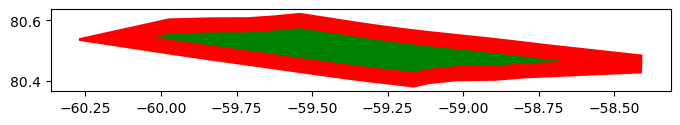

In [46]:
## Create buffer around the polygon

dis = 0.05 # m

fig, ax = plt.subplots(figsize=(8, 5))

gpd.GeoSeries(polygon_fl.buffer(dis, join_style = "mitre")).plot(ax = ax, color = "r", alpha = 1)
gpd.GeoSeries(polygon_fl).plot(ax = ax, color = "green", alpha = 1)

ax.set_aspect('equal')
plt.show()

## V3 (TBD): Create AOI based on flowline and terminus position